# Predictive Modeling of Customer Purchase Behaviour in E-Commerce: A Neural Network Approach

Continuous Assessment 1 06/10/2023 - BD & ADA Module // MSc in Data Analytics Y1 S2 - <b>Student ID 2023063
    
Data source: https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-cosmetics-shop/data

Github: https://github.com/ASM2023063/mscda-20232-ca1

## 1. Research  Understanding Phase

write 

--



## 2. Data Understanding Phase
Practical Big Data (PySparkSQL) - Part 1

In [1]:
#Import PySparkSQL
import pyspark
from pyspark.sql import SparkSession        

# Create SparkSession
spark = (SparkSession
  .builder
  .appName("SparkSQL")
  .getOrCreate())

# Path to dataset
csv_file = "file:////home/hduser/Downloads/CA1/2020-Jan.csv"

In [2]:
# Read and create a temporary view
df = (spark.read.format("csv")
  .option("inferSchema", "true")
  .option("header", "true")
  .load(csv_file))
df.createOrReplaceTempView("rawdata")

In [3]:
# Visualise inferred schema
data = spark.sql("SELECT * FROM rawdata")
data.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



In [4]:
# Display 5 first rows
data.show(5)

+--------------------+----------+----------+-------------------+-------------+--------+-----+---------+--------------------+
|          event_time|event_type|product_id|        category_id|category_code|   brand|price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+-------------+--------+-----+---------+--------------------+
|2020-01-01 00:00:...|      view|   5809910|1602943681873052386|         null| grattol| 5.24|595414620|4adb70bb-edbd-498...|
|2020-01-01 00:00:...|      view|   5812943|1487580012121948301|         null|kinetics| 3.97|595414640|c8c5205d-be43-4f1...|
|2020-01-01 00:00:...|      view|   5798924|1783999068867920626|         null|  zinger| 3.97|595412617|46a5010f-bd69-4fb...|
|2020-01-01 00:00:...|      view|   5793052|1487580005754995573|         null|    null| 4.92|420652863|546f6af3-a517-475...|
|2020-01-01 00:00:...|      view|   5899926|2115334439910245200|         null|    null| 3.92|484071203|cff70ddf-529e-4b0...|


In [5]:
# Number of users
action = spark.sql("SELECT count(distinct user_id) FROM rawdata")
action.show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                 410073|
+-----------------------+



In [6]:
# Number of events
action = spark.sql("SELECT count(distinct event_type) FROM rawdata")
action.show()

+--------------------------+
|count(DISTINCT event_type)|
+--------------------------+
|                         4|
+--------------------------+



In [7]:
# Number of products
action = spark.sql("SELECT count(distinct product_id) FROM rawdata")
action.show()

+--------------------------+
|count(DISTINCT product_id)|
+--------------------------+
|                     45484|
+--------------------------+



In [8]:
# Top seller product
countProduct = spark.sql("SELECT product_id, count(*) FROM rawdata GROUP BY product_id ORDER BY count(*) desc")
countProduct.show(5)

+----------+--------+
|product_id|count(1)|
+----------+--------+
|   5809910|   36967|
|   5809912|   14310|
|   5917178|   12634|
|   5700037|   11429|
|   5686925|   11098|
+----------+--------+
only showing top 5 rows



## 3. Data Preparation Phase

In [9]:
# New dataframe with topseller product
topseller = spark.sql("SELECT DISTINCT * FROM rawdata WHERE product_id LIKE 5809910")
topseller.show(5)

+--------------------+----------------+----------+-------------------+-------------+-------+-----+---------+--------------------+
|          event_time|      event_type|product_id|        category_id|category_code|  brand|price|  user_id|        user_session|
+--------------------+----------------+----------+-------------------+-------------+-------+-----+---------+--------------------+
|2020-01-01 00:00:...|            view|   5809910|1602943681873052386|         null|grattol| 5.24|595414620|4adb70bb-edbd-498...|
|2020-01-01 14:21:...|            view|   5809910|1602943681873052386|         null|grattol| 5.24|592285428|33ecf984-0438-459...|
|2020-01-01 16:56:...|            view|   5809910|1602943681873052386|         null|grattol| 5.24|595651372|121148f9-4e42-48b...|
|2020-01-01 18:40:...|remove_from_cart|   5809910|1602943681873052386|         null|grattol| 5.24|583351843|85fa8bff-02e8-4a5...|
|2020-01-02 06:09:...|            view|   5809910|1602943681873052386|         null|gratto

In [10]:
# Drop columns
topseller = topseller.drop(*["product_id","category_id","category_code","brand","price"])

In [11]:
# Show updated topseller df
topseller.show(10,False)

+-----------------------+----------------+---------+------------------------------------+
|event_time             |event_type      |user_id  |user_session                        |
+-----------------------+----------------+---------+------------------------------------+
|2020-01-01 00:00:00 UTC|view            |595414620|4adb70bb-edbd-4981-b60f-a05bfd32683a|
|2020-01-01 14:21:02 UTC|view            |592285428|33ecf984-0438-459c-aea6-241319336d75|
|2020-01-01 16:56:51 UTC|view            |595651372|121148f9-4e42-48ba-94eb-7aca8935940b|
|2020-01-01 18:40:56 UTC|remove_from_cart|583351843|85fa8bff-02e8-4a5f-80b8-a129ce5555e3|
|2020-01-02 06:09:01 UTC|view            |529378930|b99ea2eb-1c67-4f39-ab20-792ebfb87f93|
|2020-01-02 08:21:31 UTC|view            |595842440|b257db78-93e8-46d4-9893-56194751a4d9|
|2020-01-03 06:16:01 UTC|view            |595798798|8b2d9742-eb2f-4bbd-8387-ace81cfdef2a|
|2020-01-03 11:17:22 UTC|cart            |596055322|74521846-45da-4a1e-a61e-19fbe7f6fb82|
|2020-01-0

In [12]:
# Customer behaviour before purchasing example
# Random customer collected from filtering event_type: 'purchase' 
from pyspark.sql.functions import asc
topseller.select("event_time","event_type","user_session").filter("user_id = 431397250").orderBy(asc("event_time")).show(truncate=False)

+-----------------------+----------+------------------------------------+
|event_time             |event_type|user_session                        |
+-----------------------+----------+------------------------------------+
|2020-01-07 14:33:37 UTC|view      |d6151353-322f-4a7a-b3a4-0c4c0e52e2f5|
|2020-01-07 14:39:42 UTC|cart      |d6151353-322f-4a7a-b3a4-0c4c0e52e2f5|
|2020-01-07 18:05:19 UTC|purchase  |697d43d2-07f9-4c59-aa7c-8dca123cebc0|
+-----------------------+----------+------------------------------------+



In [13]:
# Customer behaviour before purchasing example
# Random customer collected from filtering event_type: 'purchase' 
from pyspark.sql.functions import asc
topseller.select("event_time","event_type","user_session").filter("user_id = 46383252").orderBy(asc("event_time")).show(30,truncate=False)

+-----------------------+----------+------------------------------------+
|event_time             |event_type|user_session                        |
+-----------------------+----------+------------------------------------+
|2020-01-28 06:12:26 UTC|cart      |5549dfe6-109e-497f-a9f2-01c0aecdd73f|
|2020-01-28 06:14:08 UTC|view      |5549dfe6-109e-497f-a9f2-01c0aecdd73f|
|2020-01-28 06:17:17 UTC|view      |5549dfe6-109e-497f-a9f2-01c0aecdd73f|
|2020-01-28 06:53:25 UTC|purchase  |67347fb6-2e23-4695-8d32-03829cc6fdaf|
+-----------------------+----------+------------------------------------+



In [14]:
# Sort ASC topseller df by user_id and event 
sorted_by_user_event = topseller.orderBy(["user_id","event_type"], ascending= [True, True])

In [15]:
# Return result
sorted_by_user_event.show(5,truncate=False)

+-----------------------+----------------+--------+------------------------------------+
|event_time             |event_type      |user_id |user_session                        |
+-----------------------+----------------+--------+------------------------------------+
|2020-01-28 05:41:23 UTC|view            |4661182 |ce380fb8-bfdd-49a5-949f-eeac2c349af1|
|2020-01-28 05:43:43 UTC|view            |4661182 |ce380fb8-bfdd-49a5-949f-eeac2c349af1|
|2020-01-14 09:33:54 UTC|cart            |12961898|6cb94e2c-4db2-46ac-8c11-1ced638112bc|
|2020-01-13 11:36:50 UTC|cart            |12961898|91ceb8ab-fa0f-4929-b02e-9f36a19e73a5|
|2020-01-27 09:37:44 UTC|remove_from_cart|12961898|ea56a517-171d-4740-a9f7-f628f40274c8|
+-----------------------+----------------+--------+------------------------------------+
only showing top 5 rows



In [16]:
# Group df by user_id and event_type
event_type_count_user = sorted_by_user_event.groupby('user_id','event_type').count()

In [17]:
# New df with organised data counting event_type by user_id
sorted_event_type_count_user = event_type_count_user.orderBy(["user_id","event_type"], ascending= [True, True])

In [18]:
# Display new df
sorted_event_type_count_user.show(10)

+--------+----------------+-----+
| user_id|      event_type|count|
+--------+----------------+-----+
| 4661182|            view|    2|
|12961898|            cart|    2|
|12961898|remove_from_cart|    1|
|27692594|            cart|    1|
|31272873|            cart|    1|
|31272873|remove_from_cart|    1|
|46383252|            cart|    1|
|46383252|        purchase|    1|
|46383252|            view|    2|
|47076222|            view|    5|
+--------+----------------+-----+
only showing top 10 rows



In [19]:
# Convert PySpark Dataframe to Pandas
pandas_df = sorted_event_type_count_user.toPandas()
pandas_df.head()

,user_id,event_type,count
0,4661182,view,2
1,12961898,cart,2
2,12961898,remove_from_cart,1
3,27692594,cart,1
4,31272873,cart,1


In [20]:
# Rearrange column event_type using function .pivot() from pandas lib
pandas_df = pandas_df.pivot(index='user_id',columns='event_type',values='count')
pandas_df

event_type,cart,purchase,remove_from_cart,view
user_id,,,,
4661182,NaN,NaN,NaN,2.0
12961898,2.0,NaN,1.0,NaN
27692594,1.0,NaN,NaN,NaN
31272873,1.0,NaN,1.0,NaN
46383252,1.0,1.0,NaN,2.0
...,...,...,...,...
608796694,NaN,NaN,NaN,1.0
608802103,NaN,NaN,NaN,1.0
608804936,NaN,NaN,NaN,1.0


In [21]:
# Rearrange column position
pandas_df = pandas_df.reindex(columns=['view','cart','remove_from_cart','purchase'])
pandas_df

event_type,view,cart,remove_from_cart,purchase
user_id,,,,
4661182,2.0,NaN,NaN,NaN
12961898,NaN,2.0,1.0,NaN
27692594,NaN,1.0,NaN,NaN
31272873,NaN,1.0,1.0,NaN
46383252,2.0,1.0,NaN,1.0
...,...,...,...,...
608796694,1.0,NaN,NaN,NaN
608802103,1.0,NaN,NaN,NaN
608804936,1.0,NaN,NaN,NaN


In [22]:
# Export final df to csv
pandas_df.to_csv('customer_data.csv')

## 4. Modeling Phase
Neural Network Model - Part 2

In [23]:
# Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")


# Load dataset
data = pd.read_csv("customer_data.csv")
data

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,user_id,view,cart,remove_from_cart,purchase
0,4661182,2.0,NaN,NaN,NaN
1,12961898,NaN,2.0,1.0,NaN
2,27692594,NaN,1.0,NaN,NaN
3,31272873,NaN,1.0,1.0,NaN
4,46383252,2.0,1.0,NaN,1.0
...,...,...,...,...,...
18131,608796694,1.0,NaN,NaN,NaN
18132,608802103,1.0,NaN,NaN,NaN
18133,608804936,1.0,NaN,NaN,NaN
18134,608816772,4.0,NaN,NaN,NaN


In [24]:
# Replace NaN values with 0
data = data.fillna(0)

In [25]:
data

,user_id,view,cart,remove_from_cart,purchase
0,4661182,2.0,0.0,0.0,0.0
1,12961898,0.0,2.0,1.0,0.0
2,27692594,0.0,1.0,0.0,0.0
3,31272873,0.0,1.0,1.0,0.0
4,46383252,2.0,1.0,0.0,1.0
...,...,...,...,...,...
18131,608796694,1.0,0.0,0.0,0.0
18132,608802103,1.0,0.0,0.0,0.0
18133,608804936,1.0,0.0,0.0,0.0
18134,608816772,4.0,0.0,0.0,0.0


In [26]:
# Separate features and target variable
X = data[['view', 'cart', 'remove_from_cart']]
y = data[['purchase']]

In [27]:
# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [28]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
# Build neural network (NN) model 
nnmodel = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(3,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1) #output layer, no activation function
])

In [30]:
# Compile NN model

nnmodel.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [31]:
# Train NN model
nnmodel.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
363/363 [==============================] - 1s 796us/step - loss: 0.1511 - mae: 0.1949 - val_loss: 0.0935 - val_mae: 0.1690
Epoch 2/10
363/363 [==============================] - 0s 666us/step - loss: 0.0902 - mae: 0.1564 - val_loss: 0.0915 - val_mae: 0.1546
Epoch 3/10
363/363 [==============================] - 0s 688us/step - loss: 0.0886 - mae: 0.1555 - val_loss: 0.0875 - val_mae: 0.1534
Epoch 4/10
363/363 [==============================] - 0s 693us/step - loss: 0.0875 - mae: 0.1522 - val_loss: 0.0869 - val_mae: 0.1477
Epoch 5/10
363/363 [==============================] - 0s 690us/step - loss: 0.0865 - mae: 0.1513 - val_loss: 0.0853 - val_mae: 0.1495
Epoch 6/10
363/363 [==============================] - 0s 692us/step - loss: 0.0853 - mae: 0.1498 - val_loss: 0.0895 - val_mae: 0.1597
Epoch 7/10
363/363 [==============================] - 0s 689us/step - loss: 0.0863 - mae: 0.1487 - val_loss: 0.0972 - val_mae: 0.1476
Epoch 8/10
363/363 [==============================] - 0s 652us

## 5. Evaluation Phase

In [32]:
# Evaluate NN model
loss, mae = nnmodel.evaluate(X_test, y_test)
print(f'Mean absolute error (MAE) on test data: {mae}')

114/114 [==============================] - 0s 469us/step - loss: 0.0738 - mae: 0.1488
Mean absolute error (MAE) on test data: 0.1487836241722107


In [33]:
# Make prediction
new_customer = np.array([[6,5,0]])
scaled_data = scaler.transform(new_customer)
prediction = nnmodel.predict(scaled_data)

print(f'Predicted number of purchases: {prediction[0][0]}')

1/1 [==============================] - 0s 31ms/step
Predicted number of purchases: 1.2341116666793823


## 6. Deployment Phase

In [55]:
# Hyperparameter tuning

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam
from itertools import product

In [56]:
# Define the model as a function 
def create_model(learning_rate=0.01, num_hidden_layers=2, num_neurons=32, activation='relu'):
    model = Sequential()
    model.add(Dense(num_neurons, activation=activation, input_shape=(3,)))
    
    for _ in range(num_hidden_layers - 1):
        model.add(Dense(num_neurons, activation=activation))
    
    model.add(Dense(1)) #output layer, no activation function
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return model

In [57]:
# Define hyperparameters
parameter_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'num_hidden_layers': [1, 2, 3],
    'num_neurons': [16, 32, 64],
    'activation': ['relu', 'tanh']
}

In [58]:
# Perform the grid search
best_parameter = None
best_score = float('inf')

In [59]:
for learning_rate, num_hidden_layers, num_neurons, activation in product(
    parameter_grid['learning_rate'],
    parameter_grid['num_hidden_layers'],
    parameter_grid['num_neurons'],
    parameter_grid['activation']
):
    parameter = {
        'learning_rate': learning_rate,
        'num_hidden_layers': num_hidden_layers,
        'num_neurons': num_neurons,
        'activation': activation
    }

    # Create and compile the model
    model1 = create_model(**parameter)

    # Train the model on the training set
    model1.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Evaluate the model on the validation set
    _, mae = model1.evaluate(X_test, y_test)

    if mae < best_score:
        best_score = mae
        best_parameter = parameter

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", best_parameter)
print("Best MAE Score: ", best_score)

114/114 [==============================] - 0s 458us/step - loss: 0.1475 - mae: 0.3128
Best Hyperparameters:  {'learning_rate': 0.01, 'num_hidden_layers': 3, 'num_neurons': 16, 'activation': 'relu'}
Best MAE Score:  0.1311875730752945


In [61]:
# Verifying if the model is underfitting or overfitting

overfit_model = Sequential([
    Dense(32, activation='relu', input_shape=(3,)),
    Dense(16, activation='relu'),
    Dense(1) #output layer
])

In [62]:
# Compile overfitting_model

overfit_model.compile(optimizer='adam', loss='mean_squared_error')

In [63]:
history= overfit_model.fit(X_train, y_train,epochs=10,batch_size=32,validation_data=(X_test, y_test),verbose=0)

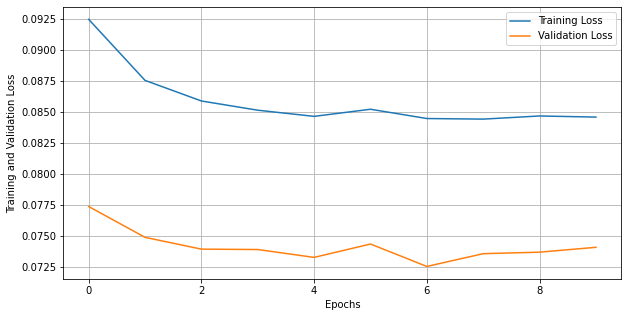

In [64]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()